In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot  as plt
from matplotlib.pyplot import imshow,imread
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
import tensorflow as tf
import os
from sklearn.preprocessing import scale,minmax_scale
from keras.utils.vis_utils import plot_model

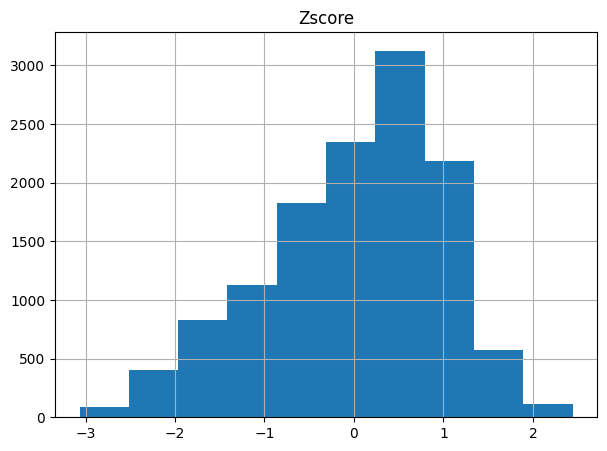

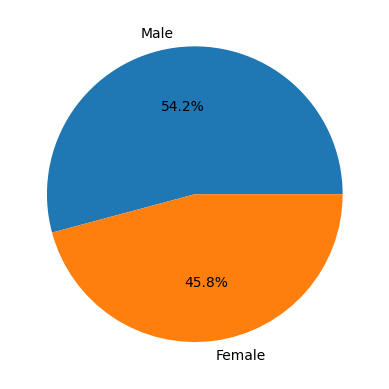

In [2]:
train_df = pd.read_csv('dataset/RSNA_Annotations/RSNA_Annotations/BONEAGE/boneage_train.csv')
train_df ['ID'] = train_df['ID'].map(lambda x: f'{x}.png')
train_df['Male']= train_df['Male'].map(lambda x: 1 if (x == True) else 0)
mean = train_df['Boneage'].mean()
stdd = train_df['Boneage'].std()
train_df['Zscore']= train_df['Boneage'].map(lambda x:(x-mean)/stdd)
plt.show(train_df[['Zscore']].hist(figsize=(7,5)))
gender_count = [sum(train_df['Male'])]
gender_count.append(len(train_df)-gender_count[0])
plt.show(plt.pie(gender_count,labels=['Male','Female'],autopct='%1.1f%%'))

In [3]:
test_df = pd.read_csv('dataset/RSNA_Annotations/RSNA_Annotations/BONEAGE/gender_test.csv')
test_df['ID'] = test_df['ID'].map(lambda x: f'{x}.png')

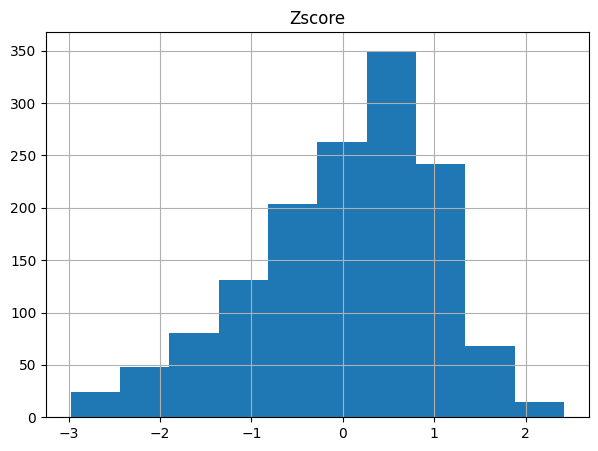

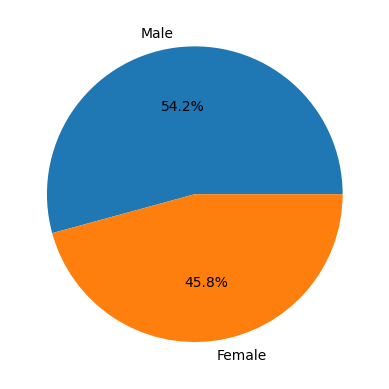

In [4]:
val_df = pd.read_csv('dataset/RSNA_Annotations/RSNA_Annotations/BONEAGE/boneage_val.csv')
val_df ['ID'] = val_df['ID'].map(lambda x: f'{x}.png')
val_df['Male']= val_df['Male'].map(lambda x: 1 if (x == True) else 0)
mean = val_df['Boneage'].mean()
stdd = val_df['Boneage'].std()
val_df['Zscore']= val_df['Boneage'].map(lambda x:(x-mean)/stdd)
plt.show(val_df[['Zscore']].hist(figsize=(7,5)))
gender_count = [sum(val_df['Male'])]
gender_count.append(len(val_df)-gender_count[0])
plt.show(plt.pie(gender_count,labels=['Male','Female'],autopct='%1.1f%%'))

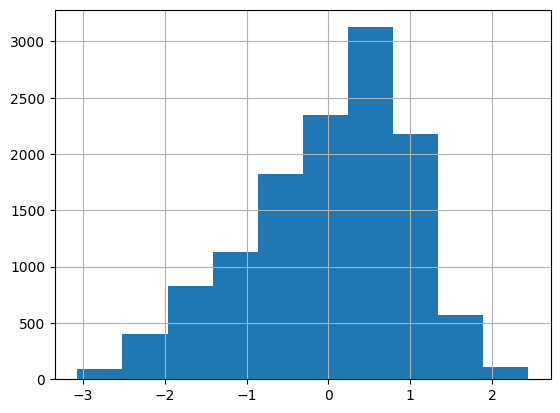

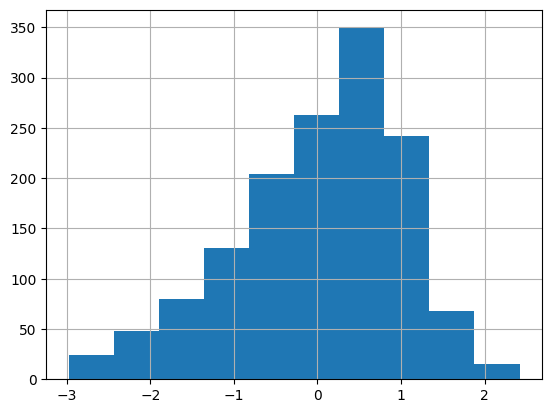

In [5]:
plt.show(train_df['Zscore'].hist())
plt.show(val_df['Zscore'].hist())

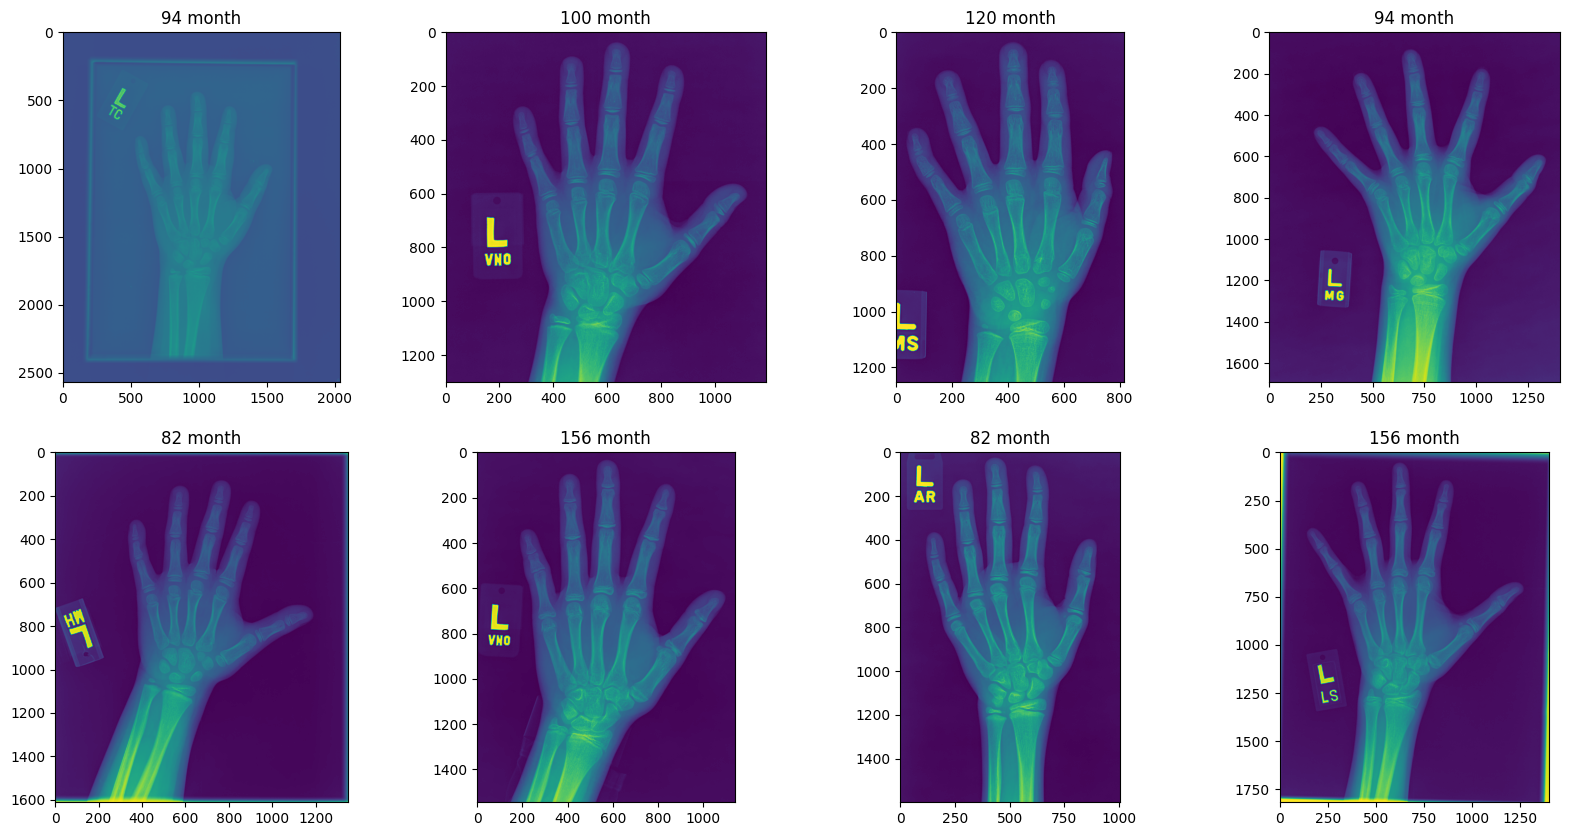

In [6]:
train_dir='dataset/RSNA_train/images'
test_dir= 'dataset/RSNA_test/images'
val_dir='dataset/RSNA_val/images/' 
sample = train_df.sample(n=8)
fig,axx = plt.subplots(2,4, figsize=(20,10))
for idd,boneage,place in zip(sample['ID'],sample['Boneage'],axx.flatten()):
    place.imshow(imread(f"{train_dir}/{idd}"))
    place.set_title(str(boneage)+' month')

In [7]:
core_dg = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.1,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    dtype=None,
    preprocessing_function = tf.keras.applications.xception.preprocess_input
)

In [8]:
train_dg = core_dg.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col="ID",
    y_col="Boneage",
    weight_col=None,
    target_size=(128, 128),
    color_mode="rgb",
    classes=None,
    class_mode="raw",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
    validate_filenames=True,
)

Found 12611 validated image filenames.


In [9]:
val_dg = core_dg.flow_from_dataframe(
    val_df,
    directory=val_dir,
    x_col="ID",
    y_col="Boneage",
    weight_col=None,
    target_size=(128, 128),
    color_mode="rgb",
    classes=None,
    class_mode="raw",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
    validate_filenames=True,
)

Found 1425 validated image filenames.


In [10]:
test_dg_core = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = tf.keras.applications.xception.preprocess_input)
test_dg = test_dg_core.flow_from_dataframe(test_df,
                                          x_col='ID',
                                          directory = test_dir,
                                          class_mode = None)

Found 200 validated image filenames.


In [11]:
dummy_dg = core_dg.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col="ID",
    y_col="Boneage",
    weight_col=None,
    target_size=(128, 128),
    color_mode="rgb",
    classes=None,
    class_mode="raw",
    batch_size=8,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
    validate_filenames=True,   
    )

Found 12611 validated image filenames.


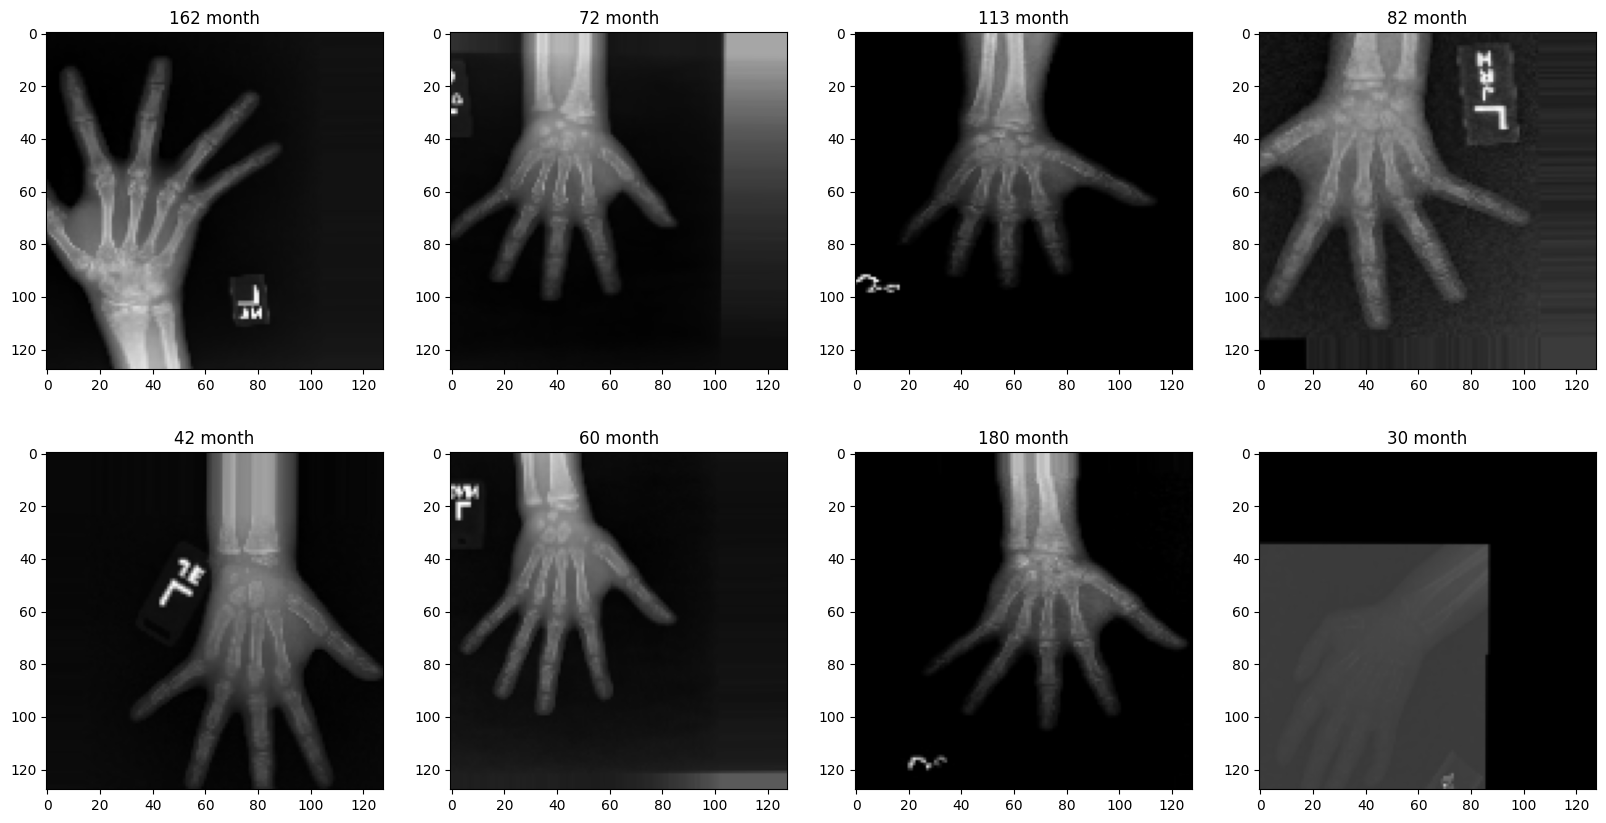

In [12]:
sample = dummy_dg.next()
fig,axx = plt.subplots(2,4, figsize=(20,10))
for img,boneage,place in zip(sample[0],sample[1],axx.flatten()):
    place.imshow(np.interp(img,(-1,1),(0,1)))
    place.set_title(str(boneage)+' month')

In [13]:
from keras import Sequential
from keras.layers import Dense,MaxPooling2D,Input,Conv2D,Dropout,BatchNormalization,GlobalMaxPooling2D,Flatten
from keras.applications.xception import Xception
from keras.metrics import MeanAbsoluteError
from keras.models import Model

In [14]:
input_shape=(128,128,3)
dropout_rate = 0.35

model_base = Xception(include_top = False,input_shape=input_shape)
model_base.trainable = True
model = Sequential()
model.add(model_base)
model.add(GlobalMaxPooling2D())
model.add(Dense(10,activation='relu'))
model.add(Dense(1,activation = 'linear'))
model.compile(loss='mse', optimizer= 'adam', metrics=[MeanAbsoluteError()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 20,881,981
Trainable params: 20,827,453
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
model.fit_generator(train_dg, epochs = 10)

In [ ]:
model.save(filepath='checkpoint_xce.h5')

In [15]:
model.load_weights('checkpoint_xce.h5')

In [16]:
score = model.evaluate(val_dg)


45/45 [==============================] - 143s 3s/step - loss: 264.1493 - mean_absolute_error: 12.6283


In [17]:
print(f"MAE for Xception model: {score[1]}")

MAE for Xception model: 12.628264427185059


In [18]:
img,lab = val_dg.next()
print(img.shape)
print(lab.shape)

(32, 128, 128, 3)
(32,)


In [19]:
pred = model.predict(img)


1/1 [==============================] - 4s 4s/step


In [20]:
for i in range(len(lab)):
    print(f"pred:{round(pred[i][0])}\ntrue:{lab[i]}\ndiff:{round(abs(pred[i][0]-lab[i]))}")
    print("-"*30)

pred:152
true:120
diff:32
------------------------------
pred:100
true:132
diff:32
------------------------------
pred:72
true:72
diff:0
------------------------------
pred:147
true:156
diff:9
------------------------------
pred:120
true:108
diff:12
------------------------------
pred:142
true:156
diff:14
------------------------------
pred:111
true:108
diff:3
------------------------------
pred:149
true:132
diff:17
------------------------------
pred:97
true:120
diff:23
------------------------------
pred:140
true:120
diff:20
------------------------------
pred:124
true:150
diff:26
------------------------------
pred:131
true:132
diff:1
------------------------------
pred:136
true:150
diff:14
------------------------------
pred:147
true:120
diff:27
------------------------------
pred:157
true:168
diff:11
------------------------------
pred:128
true:106
diff:22
------------------------------
pred:155
true:156
diff:1
------------------------------
pred:66
true:78
diff:12
---------------